In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sn
import pickle

# List of Dictionarys

> - ADP_outputs:
    - 'iteration_i':
        - 'granularity_j':
            - 'centre': 
            - 'IDX': 
            - 'Param':
            - 'n_data_clouds': int
            
            
> - data_clouds_dic:
    - 'iteration_i':
        - 'granularity_j':
            - 'data_cloud_k': 
                - 'data':
                - 'target':
                
> - data_clouds_info:
    - 'iteration_i':
        - 'granularity_j':
            - 'n_data_clouds': int
            - 'n_events_p_dc': 
                - 'data_cloud_k': int
            - 'n_anom_p_dc': 
                - 'data_cloud_l': int

> - accuracy_dict:
    - 'iteration_i':
        - 'granularity_j':
            - 'data_cloud_k': 
                - 'One-Class SVM', 'Isolation Forest', 'Local Outlier Factor':
                    - 'True_Positive': int
                    - 'True_Negative': int
                    - 'False_Positive': int
                    - 'False_Negative': int
                    - 'Time': int


# Análise da Base

In [4]:
aux = []
for i in range(33):

    ### Loading data analysis result 

    with open('kernel/SODA_outputs_iteration_' + str(i) + '.pkl', 'rb') as fp:
        ADP_outputs = pickle.load(fp)
    with open('kernel/data_clouds_dic_iteration_' + str(i) + '.pkl', 'rb') as fp:
        data_clouds_dic = pickle.load(fp)
    with open('kernel/data_clouds_info_iteration_' + str(i) + '.pkl', 'rb') as fp:
        data_clouds_info = pickle.load(fp)

    # Computing weighted mean of the anomaly percent in each granularity

    aux2 = []
    for gra in data_clouds_info:
        aux3 = []
        n_tot_events = 0            
        for dc in data_clouds_info[gra]['n_events_p_dc']:
            percent = (data_clouds_info[gra]['n_anom_p_dc'][dc]/
                        data_clouds_info[gra]['n_events_p_dc'][dc])
            aux3.append(percent * data_clouds_info[gra]['n_events_p_dc'][dc])
            n_tot_events += data_clouds_info[gra]['n_events_p_dc'][dc]
        aux2.append(sum(aux3)/n_tot_events)
    aux.append(aux2)

# Computing mean and std deviation over the iterations

percent_mean = []
percent_std = []
for i in range(len(aux[0])):
    percent_mean.append(np.mean(aux[:][i]))
    percent_std.append(np.std(aux[:][i]))

# Converting to numpy array

percent_mean = np.array(percent_mean)
percent_std = np.array(percent_std)

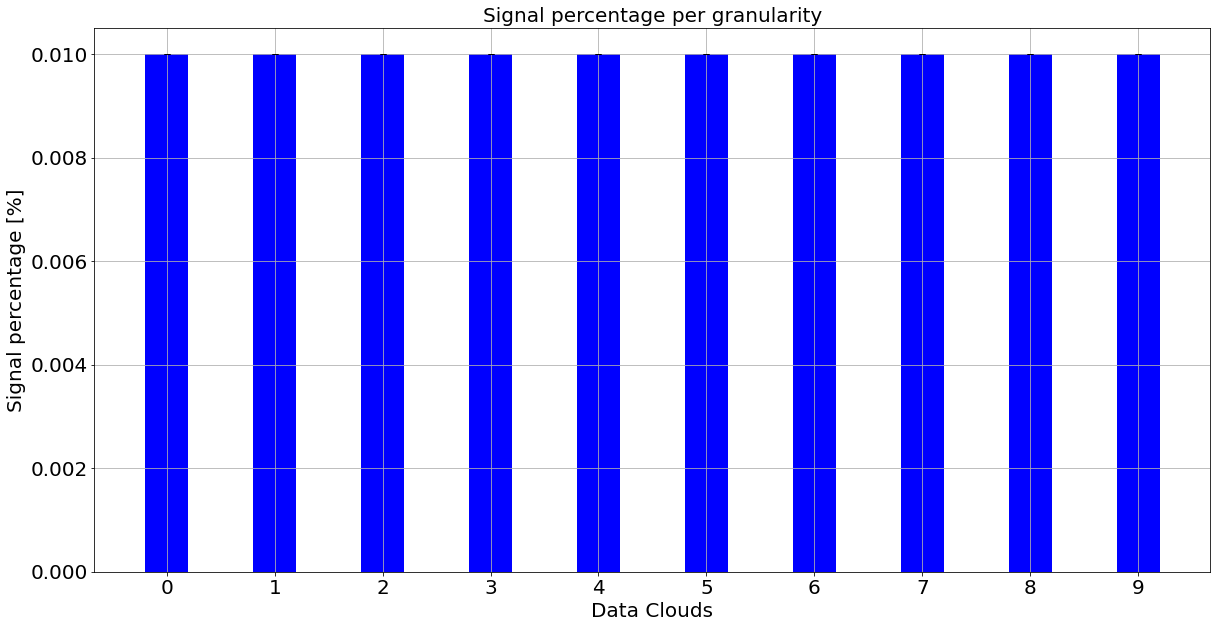

In [5]:
plt.figure(figsize=(20,10))
ax = plt.subplot()

x = range(len(percent_mean))

ax.bar(x,percent_mean, width=0.4, color='b', align='center')

plt.plot([x,x], [percent_mean[:] - percent_std[:], 
                     percent_mean[:] + percent_std[:]], 'k_-')

ax.set_xticks(x)
ax.set_title('Signal percentage per granularity', fontsize=20)
ax.set_ylabel('Signal percentage [%]', fontsize=20)
ax.set_xlabel('Data Clouds', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/True_Positive_Rate.png', bbox_inches='tight')
plt.show()

# Análise do Modelo

In [27]:
results_df = pd.DataFrame(columns = ['Granularity',
                                     'True_Positive_Rate_Mean', 'True_Positive_Rate_Std',
                                     'False_Positive_Rate_Mean', 'False_Positive_Rate_Std',
                                     'True_Positive_Mean', 'True_Positive_Std',
                                     'True_Negative_Mean', 'True_Negative_Std',
                                     'False_Positive_Mean', 'False_Positive_Std',
                                     'False_Negative_Mean', 'False_Negative_Std',
                                     'N_Groups_Mean', 'N_Groups_Std',
                                     'Execution_Time_Mean', 'Execution_Time_Std'])

iterations = 1
aux = {}
for it in range(iterations):

    ### Loading data analysis result 

    with open('kernel/accuracy_dict_iteration_' + str(it) + '.pkl', 'rb') as fp:
        accuracy_dict = pickle.load(fp)
        
    aux2 = {}
    for gra in accuracy_dict:
        aux3 = {
                'One-Class SVM':{
                    'True_Positive':0,
                    'True_Negative':0,
                    'False_Positive':0,
                    'False_Negative':0,
                    'Time':0,
                    'True_Positive_Rate':0,
                    'False_Positive_Rate':0
                                }, 
                'Isolation Forest':{
                    'True_Positive':0,
                    'True_Negative':0,
                    'False_Positive':0,
                    'False_Negative':0,
                    'Time':0,
                    'True_Positive_Rate':0,
                    'False_Positive_Rate':0
                                }, 
                'Local Outlier Factor':{
                    'True_Positive':0,
                    'True_Negative':0,
                    'False_Positive':0,
                    'False_Negative':0,
                    'Time':0,
                    'True_Positive_Rate':0,
                    'False_Positive_Rate':0
                                }
            }
        for dc in accuracy_dict[gra]:
            n_mono = 0
            for model in accuracy_dict[gra][dc]:
                if accuracy_dict[gra][dc][model] == 'mono_event':
                    n_mono += 1
                
                else:
                    aux3[model]['True_Positive'] += accuracy_dict[gra][dc][model]['True_Positive']
                    aux3[model]['True_Negative'] += accuracy_dict[gra][dc][model]['True_Negative']
                    aux3[model]['False_Positive'] += accuracy_dict[gra][dc][model]['False_Positive']
                    aux3[model]['False_Negative'] += accuracy_dict[gra][dc][model]['False_Negative']
                    aux3[model]['Time'] += accuracy_dict[gra][dc][model]['Time']
        
        print(n_mono)

        for model in aux3:   
            tp = aux3[model]['True_Positive']
            tn = aux3[model]['True_Negative']
            fp = aux3[model]['False_Positive']
            fn = aux3[model]['False_Negative']

            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
                
            aux3[model]["True_Positive_Rate"] = tpr*100
            aux3[model]["False_Positive_Rate"] = fpr*100
        
        aux2[gra] = aux3
    aux['iteration_'+str(it)] = aux2

0
0
0
0
0
0
0
3
3
3


In [28]:
results_dict = {

    'One-Class SVM':{}, 
    'Isolation Forest':{}, 
    'Local Outlier Factor':{}
    
}
for model in results_dict:
    results_df = pd.DataFrame(columns = ['Granularity',
                                         'True_Positive_Rate_Mean', 'True_Positive_Rate_Std',
                                         'False_Positive_Rate_Mean', 'False_Positive_Rate_Std',
                                         'True_Positive_Mean', 'True_Positive_Std',
                                         'True_Negative_Mean', 'True_Negative_Std',
                                         'False_Positive_Mean', 'False_Positive_Std',
                                         'False_Negative_Mean', 'False_Negative_Std',
                                         'Execution_Time_Mean', 'Execution_Time_Std'])
    
    for i,gra in enumerate(aux['iteration_0']):
        tpr = []
        fpr = []
        tp = []
        tn = []
        fp = []
        fn = []
        time =[]

        for it in aux:
            tpr.append(aux[it][gra][model]['True_Positive_Rate'])
            fpr.append(aux[it][gra][model]['False_Positive_Rate'])
            tp.append(aux[it][gra][model]['True_Positive'])
            tn.append(aux[it][gra][model]['True_Negative'])
            fp.append(aux[it][gra][model]['False_Positive'])
            fn.append(aux[it][gra][model]['False_Negative'])
            time.append(aux[it][gra][model]['Time'])
    
        aux4 = {'Granularity':i+1,
                        'True_Positive_Rate_Mean': np.mean(tpr),
                        'True_Positive_Rate_Std': np.std(tpr),
                        'False_Positive_Rate_Mean': np.mean(fpr),
                        'False_Positive_Rate_Std': np.std(fpr),
                        'True_Positive_Mean': np.mean(tp),
                        'True_Positive_Std': np.std(tp),
                        'True_Negative_Mean': np.mean(tn),
                        'True_Negative_Std': np.std(tn),
                        'False_Positive_Mean': np.mean(fp),
                        'False_Positive_Std': np.std(fp),
                        'False_Negative_Mean': np.mean(fn),
                        'False_Negative_Std': np.std(fn),
                        'Execution_Time_Mean': np.mean(time),
                        'Execution_Time_Std': np.std(time)
               }
        results_df = results_df.append(aux4, ignore_index=True)
    results_df.to_csv('results/' + str(model) + '_results_df.csv')
    results_dict[model] = results_df

In [29]:
results_dict.keys()

dict_keys(['One-Class SVM', 'Isolation Forest', 'Local Outlier Factor'])

In [36]:
model = 'Isolation Forest'
df = results_dict[model]

In [43]:
df

,Granularity,True_Positive_Rate_Mean,True_Positive_Rate_Std,False_Positive_Rate_Mean,False_Positive_Rate_Std,True_Positive_Mean,True_Positive_Std,True_Negative_Mean,True_Negative_Std,False_Positive_Mean,False_Positive_Std,False_Negative_Mean,False_Negative_Std,Execution_Time_Mean,Execution_Time_Std
0,1.0,0.000000,0.0,1.010101,0.0,0.0,0.0,980.0,0.0,10.0,0.0,10.0,0.0,0.269687,0.0
1,2.0,0.000000,0.0,1.111111,0.0,0.0,0.0,979.0,0.0,11.0,0.0,10.0,0.0,0.456491,0.0
2,3.0,0.000000,0.0,1.414141,0.0,0.0,0.0,976.0,0.0,14.0,0.0,10.0,0.0,1.595276,0.0
3,4.0,0.000000,0.0,2.325581,0.0,0.0,0.0,966.0,0.0,23.0,0.0,10.0,0.0,3.645543,0.0
4,5.0,0.000000,0.0,5.369807,0.0,0.0,0.0,934.0,0.0,53.0,0.0,10.0,0.0,11.701608,0.0
5,6.0,20.000000,0.0,7.995846,0.0,2.0,0.0,886.0,0.0,77.0,0.0,8.0,0.0,23.146897,0.0
6,7.0,20.000000,0.0,12.934783,0.0,2.0,0.0,801.0,0.0,119.0,0.0,8.0,0.0,30.648733,0.0
7,8.0,10.000000,0.0,15.438596,0.0,1.0,0.0,723.0,0.0,132.0,0.0,9.0,0.0,38.625777,0.0
8,9.0,22.222222,0.0,17.866324,0.0,2.0,0.0,639.0,0.0,139.0,0.0,7.0,0.0,46.542294,0.0
9,10.0,25.000000,0.0,16.268657,0.0,2.0,0.0,561.0,0.0,109.0,0.0,6.0,0.0,50.359233,0.0


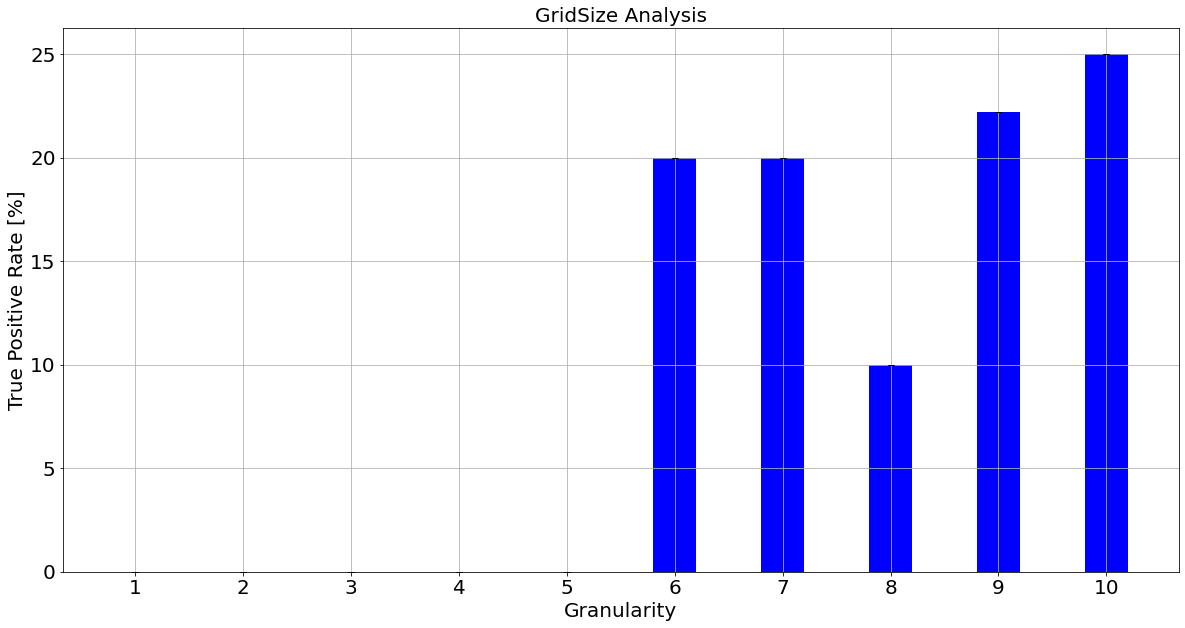

In [44]:
list_gra = range(1,11)

x = np.array((list_gra))

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, df['True_Positive_Rate_Mean'], width=0.4, color='b', align='center')

plt.plot([x,x], [df['True_Positive_Rate_Mean'] - df['True_Positive_Rate_Std'], 
                     df['True_Positive_Rate_Mean'] + df['True_Positive_Rate_Std']], 'k_-')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('True Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/True_Positive_Rate_' + str(model) + '.png', bbox_inches='tight')
plt.show()

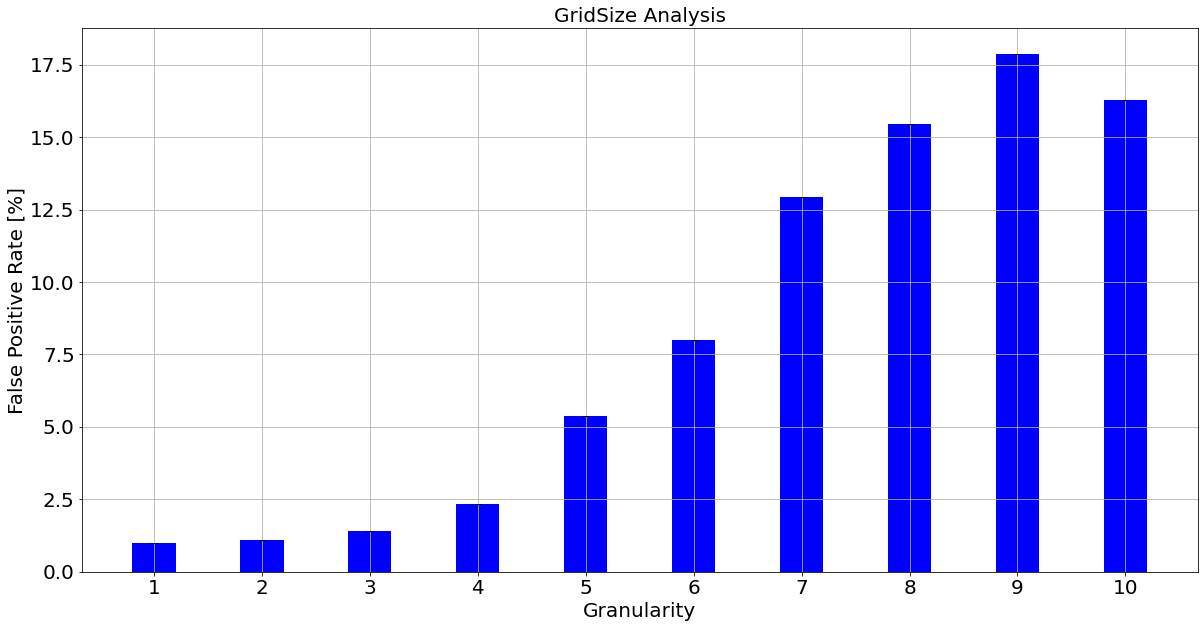

In [45]:
x = np.array(list_gra)

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, df['False_Positive_Rate_Mean'], width=0.4, color='b', align='center')


plt.plot([x,x], [df['False_Positive_Rate_Mean'] - df['False_Positive_Rate_Std'], 
                     df['False_Positive_Rate_Mean'] + df['False_Positive_Rate_Std']], 'k_-')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('False Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)


# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/False_Positive_Rate_' + str(model) + '.png', bbox_inches='tight')
plt.show()

# Tempo de Execução

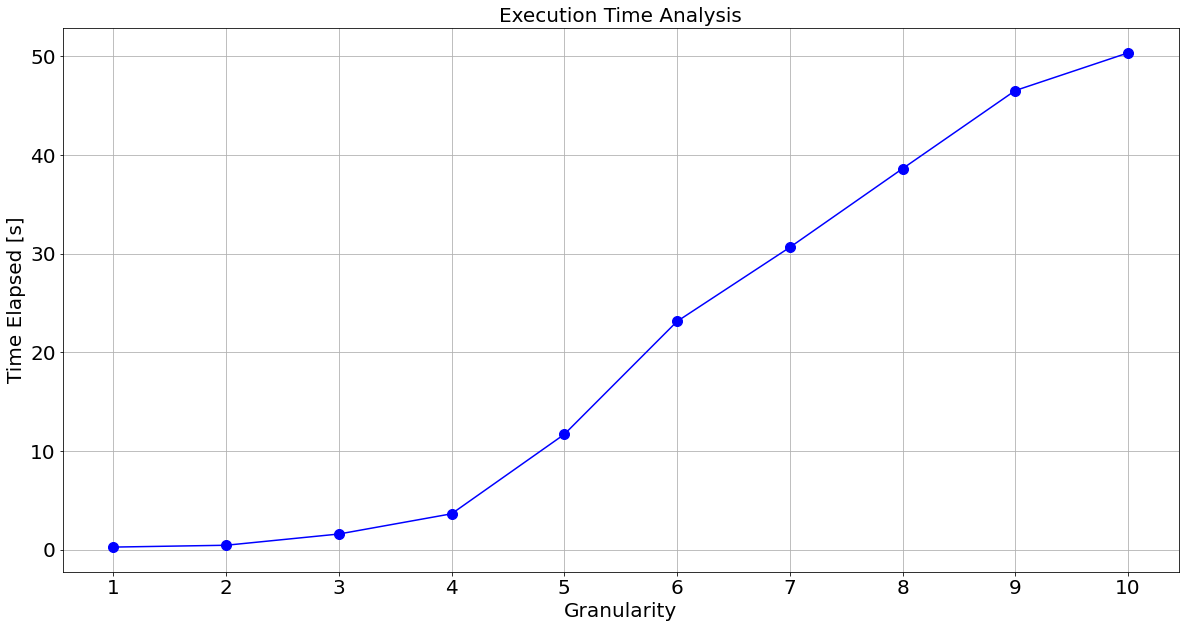

In [46]:
plt.figure(figsize=(20,10))
ax = plt.subplot()



ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Execution Time Analysis', fontsize=20)
ax.set_ylabel('Time Elapsed [s]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

ax.set_xticks(x)

plt.plot([x,x], [df['Execution_Time_Mean'] - df['Execution_Time_Std'], 
                     df['Execution_Time_Mean'] + df['Execution_Time_Std']], 'k_-')

plt.plot(df['Granularity'], df['Execution_Time_Mean'], 'b.-', markersize=20)
plt.grid()

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'r.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='r')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('results/Execution_time_2_' + str(model) + '.png', bbox_inches='tight')
plt.show()

# ROC

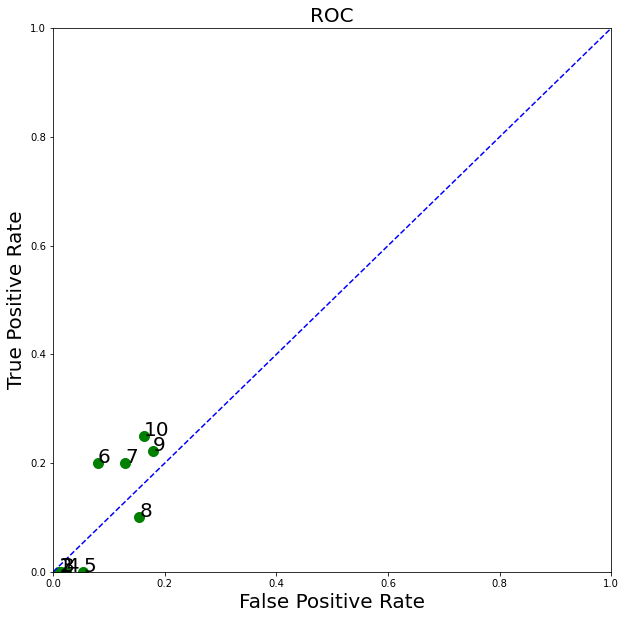

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df['False_Positive_Rate_Mean']/100, df['True_Positive_Rate_Mean']/100, c='g', s=100)
for i, txt in enumerate(x):
    ax.annotate(txt, (df['False_Positive_Rate_Mean'][i]/100, df['True_Positive_Rate_Mean'][i]/100), fontsize=20)    

ax.set_title('ROC', fontsize=20)
ax.plot([0, 1], [0, 1],'b--')    
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.savefig('results/ROC_2_' + str(model) + '.png', bbox_inches='tight')

plt.show()

In [37]:
df[df['Granularity'] == 5]

,Granularity,True_Positive_Rate_Mean,True_Positive_Rate_Std,False_Positive_Rate_Mean,False_Positive_Rate_Std,True_Positive_Mean,True_Positive_Std,True_Negative_Mean,True_Negative_Std,False_Positive_Mean,False_Positive_Std,False_Negative_Mean,False_Negative_Std,Execution_Time_Mean,Execution_Time_Std
4,5.0,0.0,0.0,5.369807,0.0,0.0,0.0,934.0,0.0,53.0,0.0,10.0,0.0,11.701608,0.0


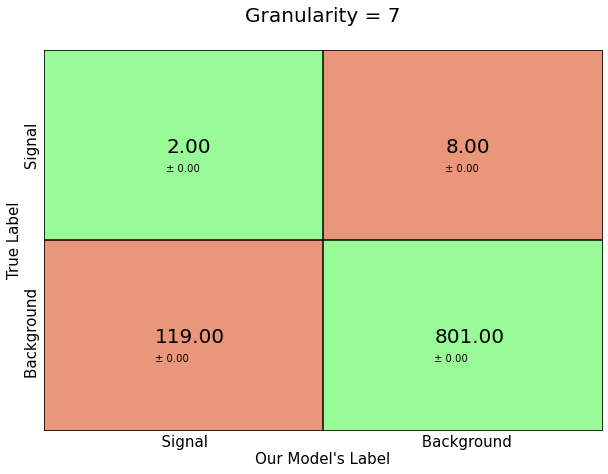

In [39]:
gra = 7


matrix = [ float(df[df['Granularity'] == gra]["True_Positive_Mean"]),  
           float(df[df['Granularity'] == gra]["False_Negative_Mean"]),
           float(df[df['Granularity'] == gra]["False_Positive_Mean"]), 
           float(df[df['Granularity'] == gra]["True_Negative_Mean"])]

matrix2 = [ float(df[df['Granularity'] == gra]["True_Positive_Std"]),  
           float(df[df['Granularity'] == gra]["False_Negative_Std"]),
           float(df[df['Granularity'] == gra]["False_Positive_Std"]), 
           float(df[df['Granularity'] == gra]["True_Negative_Std"])]


fig = plt.figure(figsize=[10,7])
        
y_label = ['Anomaly Event', 'Normal Event']
x_label = ['Anomaly Event', 'Normal Event']


plt.plot([0,2],[1,1], color='k')
plt.plot([1,1],[0,2], color='k')


plt.fill_between([0,1],[1,1],[2,2], color='palegreen')
plt.fill_between([1,2],[1,1],[2,2], color='darksalmon')
plt.fill_between([0,1],[0,0],[1,1], color='darksalmon')
plt.fill_between([1,2],[0,0],[1,1], color='palegreen')


for i in range(4):
    if i < 2:
        y = 1.46
    else:
        y = 0.46
        
    if i % 2 == 0:
        x = 0.5
    else:
        x = 1.5
    a = len(list(str(matrix[i])))
    x = x - a*0.02
    
    plt.annotate('{:.2f}'.format(matrix[i]), (x, y), fontsize=20)
    plt.annotate('\u00B1 {:.2f}'.format(matrix2[i]), (x, y-0.1), fontsize=10)

plt.title('Granularity = {}\n'.format(gra), fontsize=20)
plt.xticks([])
plt.yticks([])
plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel("      Signal                                             Background\nOur Model's Label", fontsize=15)
plt.ylabel("True Label\nBackground                         Signal    ", fontsize=15)
plt.grid(False)
plt.show()

In [41]:
plt.figure(figsize=(20,10))
ax = plt.subplot()

plt.plot(df['Granularity'], df['N_Groups_Mean'], 'b.-', markersize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Groups Division Analysis', fontsize=20)
ax.set_ylabel('Number of Groups', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

palette = sn.color_palette()[0]

# Plot da sombra entre a media e o maximo e minimo instantaneo
plt.fill_between(x,df['N_Groups_Mean'], df['N_Groups_Mean']+df['N_Groups_Std'], alpha=.4, color=palette)
plt.fill_between(x,df['N_Groups_Mean'], df['N_Groups_Mean']-df['N_Groups_Std'], alpha=.4, color=palette)

ax.set_xticks(x)

plt.grid()

plt.savefig('results/Number_of_Groups.png', bbox_inches='tight')
plt.show()

KeyError: 'N_Groups_Mean'